In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn.metrics import (
    accuracy_score, top_k_accuracy_score, f1_score, matthews_corrcoef, 
    classification_report, precision_recall_fscore_support, 
    confusion_matrix, ConfusionMatrixDisplay
)

In [4]:
!ls /kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.csv  dev.txt  test.csv  test.txt  train.csv  train.txt


In [5]:
# For this model we'll use the 20k dataset no preprocessing
dataset_dir = "/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/"

In [6]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [7]:
# Load the data
train_data = get_raw_data(dataset_dir + 'train.txt')

In [8]:
# View the first 20 lines from the dataset text file
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In [9]:
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'): # check if current line is an abstract start (line -> ###[abstract_id]\n)
            abstract_id = int(line.replace('###', '').replace('\n', '')) # get abstract id
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end (line -> '\n')
            abstract_data_split = abstract_data.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {} # store lines in dictionary
                target_text_split = abstract_line.split("\t") # split target label from text 
                
                line_data["abstract_id"] = abstract_id # get abstract id
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}' # create id for each line
                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines (counter starts at 1)
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}' # embed line_number & total_lines into one feature 
                line_data["target"] = target_text_split[0] # get target label
                
                abstract_samples.append(line_data) # append line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line is a abstract text line (line -> [TARGET]\t[abstract_text])
            abstract_data += line

    return abstract_samples

In [10]:
%%time
# Get train data from file and preprocess it
train_samples = preprocess_raw_data(dataset_dir + "train.txt")

CPU times: user 571 ms, sys: 160 ms, total: 731 ms
Wall time: 744 ms


In [11]:
%%time
# Get dev/validation data from file and preprocess it
val_samples = preprocess_raw_data(dataset_dir + "dev.txt")

CPU times: user 92.4 ms, sys: 27.1 ms, total: 119 ms
Wall time: 222 ms


In [12]:
%%time
# Get test data from file and preprocess it
test_samples = preprocess_raw_data(dataset_dir + "test.txt")

CPU times: user 85.8 ms, sys: 29.2 ms, total: 115 ms
Wall time: 191 ms


In [13]:
train_count = len(train_samples)
val_count = len(val_samples)
test_count = len(test_samples)
total = train_count + val_count + test_count

In [14]:
print(f'train samples count:\t\t{train_count}')
print(f'dev/validation samples count:\t{val_count}')
print(f'test samples count:\t\t{test_count}')

print(f'\ntotal samples:\t\t\t{total}')

train samples count:		180040
dev/validation samples count:	30212
test samples count:		30135

total samples:			240387


In [15]:
# View first 10 abstracts from the train set
train_samples[:10]

[{'abstract_id': 24293578,
  'line_id': '24293578_0_12',
  'abstract_text': 'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 12,
  'current_line': '0_12',
  'target': 'OBJECTIVE'},
 {'abstract_id': 24293578,
  'line_id': '24293578_1_12',
  'abstract_text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'line_number': 1,
  'total_lines': 12,
  'current_line': '1_12',
  'target': 'METHODS'},
 {'abstract_id': 24293578,
  'line_id': '24293578_2_12',
  'abstract_text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12,

In [16]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [17]:
# View the first 20 samples in train_df
train_df.head(20)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS
5,24293578,24293578_5_12,"Serum levels of interleukin 1 ( IL-1 ) , IL-6 ...",5,12,5_12,METHODS
6,24293578,24293578_6_12,There was a clinically relevant reduction in t...,6,12,6_12,RESULTS
7,24293578,24293578_7_12,The mean difference between treatment arms ( 9...,7,12,7_12,RESULTS
8,24293578,24293578_8_12,"Further , there was a clinically relevant redu...",8,12,8_12,RESULTS
9,24293578,24293578_9_12,These differences remained significant at 12 w...,9,12,9_12,RESULTS


<a id=2.3></a>
### Inspect Train Data Distribution

In [18]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

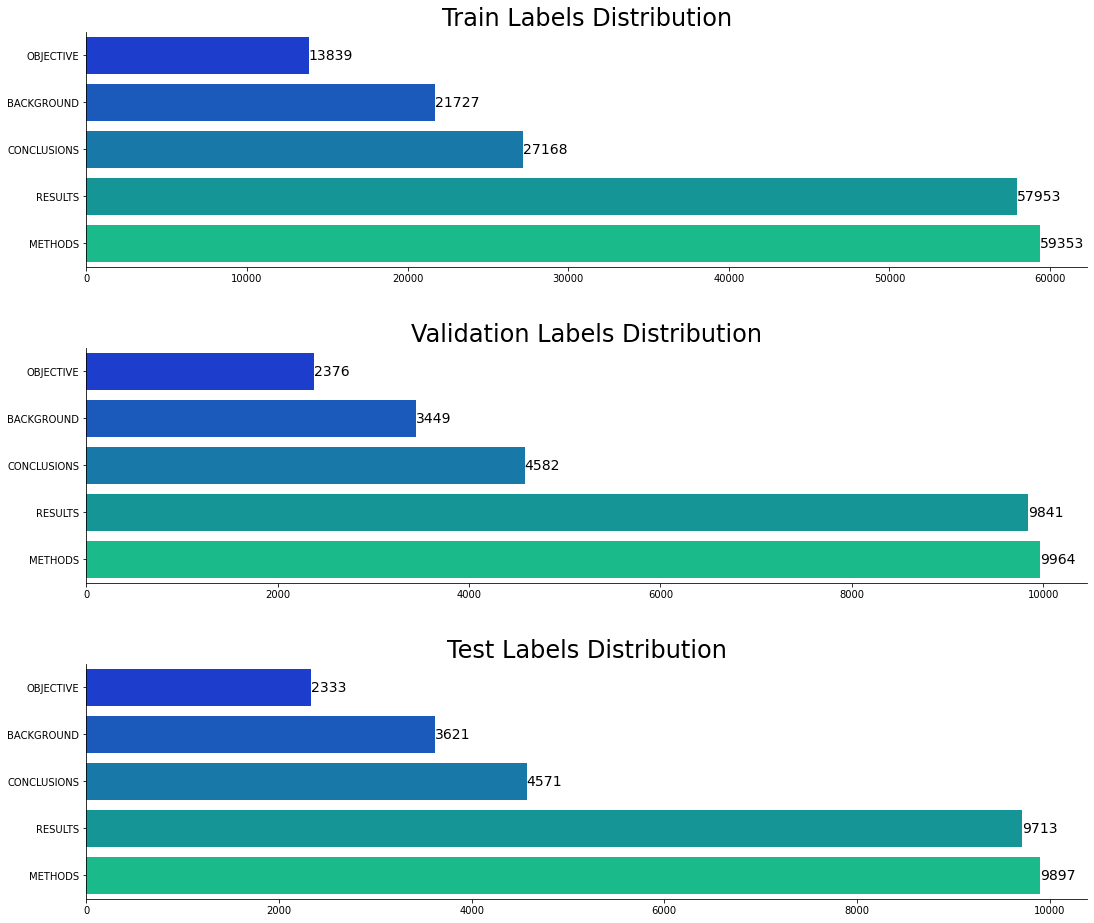

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 14))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)
sns.despine();
# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=24)
train_distribution = train_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax1);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=24)
val_distribution = val_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h", palette=sns.color_palette("winter", 5),
            ax=ax2);
for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
    
# Plot Test Labels Distribution
ax3.set_title('Test Labels Distribution', fontsize=24)
test_distribution = test_df['target'].value_counts().sort_values()
bar_plot = sns.barplot(
    x=test_distribution.values,
    y=list(test_distribution.keys()),
    orient="h", palette=sns.color_palette("winter", 5),
    ax=ax3);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);


In [20]:
# Convert abstract text lines into lists
train_sentences = train_df["abstract_text"].tolist()
val_sentences = val_df["abstract_text"].tolist()
test_sentences = test_df["abstract_text"].tolist()

In [21]:
train_sentences_count = len(train_sentences)
val_sentences_count = len(val_sentences)
test_sentences_count = len(test_sentences)
total_sentences_count = train_sentences_count + val_sentences_count + test_sentences_count

print(f'Train samples count:\t\t{train_sentences_count}')
print(f'Dev/Validation sample count:\t{val_sentences_count}')
print(f'Test sample count:\t\t{test_sentences_count}')
print(f'Total samples:\t\t\t{total_sentences_count}')

Train samples count:		180040
Dev/Validation sample count:	30212
Test sample count:		30135
Total samples:			240387


In [22]:
# View first 5 lines of train sentences
train_sentences[:5]

['To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( 0-100 mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .']

<a id=3.2></a>
### One-Hot Encode Targets

In [23]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [24]:
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

In [25]:
train_df["target"][0]

'OBJECTIVE'

In [26]:
# inspect one hot encoded targets
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

<a id=3.3></a>
### Label Encode Targets

In [27]:
label_encoder = LabelEncoder()

In [28]:
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# inspect label encoded targets
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [29]:
# Get class names and number of classes from label_encoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

print(f'Number of classes: {num_classes}')
print(f'Classes: {class_names}')

Number of classes: 5
Classes: ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


<a id=3.4></a>
### One-Hot Encode `current_lines`

In [30]:
line_one_hot_encoder = OneHotEncoder(sparse=False)

In [31]:
%%time
train_lines_encoded = line_one_hot_encoder.fit_transform(train_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
val_lines_encoded = line_one_hot_encoder.transform(val_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)
test_lines_encoded = line_one_hot_encoder.transform(test_df["current_line"].to_numpy().reshape(-1, 1)).astype(np.float32)

CPU times: user 498 ms, sys: 1.12 s, total: 1.62 s
Wall time: 1.62 s


In [32]:
test_lines_encoded.shape

(30135, 460)

<a id=3.5></a>
### Apply Smoothing to `current_lines` encodings

In [33]:
def apply_smoothing(line_one_hot, esp=0.01):
    return np.abs(line_one_hot - esp)

def revert_smoothing(line_one_hot_smooth, esp=0.01):
    unsmooth = line_one_hot_smooth
    
    unsmooth[unsmooth>esp] = 1.0
    unsmooth[unsmooth<=esp] = 0.0
    
    return unsmooth

In [34]:
# Only apply smoothing to train lines feature 
train_lines_encoded = apply_smoothing(train_lines_encoded)

In [35]:
def create_pipeline(features, labels, batch_size=32, shuffle=False, cache=False, prefetch=False) -> tf.data.Dataset:
    '''
    Generates an input pipeline using the tf.data API for training and inference.
    
    @params
        - features: (tuple) -> tuple containing the feature data 
        - labels: (tf.Tensor | np.ndarray, default=None) -> target data related to the feature data
        - batch_size: (int) -> size for batched (default=32) 
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (bool) -> condition for caching data, data is cached in memory when True (default=False)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)
        
    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with features and labels
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)
    
    # Apply caching based on condition
    # Note: Do this if the data is small enough to fit in memory!!!
    if cache:
        ds = ds.cache(buffer_size=AUTOTUNE)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [36]:
BATCH_SIZE = 32

# Create preprocessed training dataset
train_features = (train_sentences, train_lines_encoded.astype(np.float32)) 
train_labels = train_labels_one_hot.astype(np.float32)

# Create preprocessed train input data pipeline
train_ds = create_pipeline(
    train_features, train_labels, 
    batch_size=BATCH_SIZE, shuffle=True, 
    cache=False, prefetch=True)

In [37]:
# Create preprocessed validation dataset
val_features = (val_sentences, val_lines_encoded.astype(np.float32)) 
val_labels = val_labels_one_hot.astype(np.float32)

# Create preprocessed validation input data pipeline
val_ds = create_pipeline(val_features, val_labels, 
                         batch_size=BATCH_SIZE, shuffle=False, 
                         cache=False, prefetch=True)

In [38]:
# Create preprocessed test dataset
test_features = (test_sentences, test_lines_encoded.astype(np.float32)) 
test_labels = test_labels_one_hot.astype(np.float32)

# Create preprocessed test input data pipeline
test_ds = create_pipeline(test_features, test_labels, 
                          batch_size=BATCH_SIZE, shuffle=False, 
                          cache=False, prefetch=True)

In [39]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <PrefetchDataset shapes: (((None,), (None, 460)), (None, 5)), types: ((tf.string, tf.float32), tf.float32)>
Validation Input Data Pipeline:

 <PrefetchDataset shapes: (((None,), (None, 460)), (None, 5)), types: ((tf.string, tf.float32), tf.float32)>
Test Input Data Pipeline:

 <PrefetchDataset shapes: (((None,), (None, 460)), (None, 5)), types: ((tf.string, tf.float32), tf.float32)>


In [40]:
# install your version of tensorflow_text here 

In [41]:
# When using tensorflow_text, uncomment the line below to import the module
# import tensorflow_text as text

# Here's a function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link,
                          trainable=model_trainable,
                          name=model_name)

In [42]:
# get Universal Sentence Encoder here
encoder_link = 'https://tfhub.dev/google/universal-sentence-encoder/4'
encoder_name = 'universal_sentence_encoder'
encoder_trainable=False # set trainable to False for inference-only 

encoder = get_tfhub_model(encoder_link, encoder_name, model_trainable=encoder_trainable)

<a id=5.2></a>
### Define Model Constructor

In [43]:
class SelfAttentionBlock(layers.Layer):
    
    def __init__(self, units: int, activation='gelu', kernel_initializer='GlorotNormal', **kwargs):
        super(SelfAttentionBlock, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kernel_initializer = tf.keras.initializers.deserialize(kernel_initializer)
        
        self.query = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, 
                                 return_sequences=True, name=f'block_query_lstm')
        
        self.value = layers.LSTM(self.units, activation=self.activation, 
                                 kernel_initializer=self.kernel_initializer, go_backwards=True, 
                                 return_sequences=True, name=f'block_value_lstm')
        
        self.attention = layers.AdditiveAttention(name='block_attention')
        self.average_pooler = layers.GlobalAveragePooling1D(name='block_average_pooler')
        self.query_batch_norm = layers.BatchNormalization(name='block_query_batch_norm')
        self.attention_batch_norm = layers.BatchNormalization(name='block_attention_batch_norm')
        self.residual = layers.Add(name='block_residual')
        
        
    def __call__(self, x):
        # Expand dimensions for LSTMs
        dim_expand_layer = layers.Lambda(lambda embedding: tf.expand_dims(embedding, axis=1), name='block_dim_expand')
        x_expanded = dim_expand_layer(x)
        
        # Generate LSTM sequences
        block_query = self.query(x_expanded)
        block_value = self.value(x_expanded)
        
        # Apply self-attention to LSTM 
        block_attention = self.attention([block_query, block_value])
        
        # Apply GlobalAvgPooling and BatchNorm to ensure output shape is 1D 
        block_query_pooling = self.average_pooler(block_query)
        block_query_batch_norm = self.query_batch_norm(block_query_pooling)
        
        block_attention_pooling = self.average_pooler(block_attention)
        block_attention_batch_norm = self.attention_batch_norm(block_attention_pooling)
        
        # Generate addition residual with processed query and attention
        block_residual = self.residual([block_query_batch_norm, block_attention_batch_norm])
        
        return block_residual

In [44]:
def build_model():
    # Model Inputs
    #------------
    abstract_input = layers.Input(shape=[], dtype=tf.string, name='abstract_text_input')    
    abstract_current_line = layers.Input(shape=(460), dtype=tf.float32, name='abstract_current_line')
    
    # Define Layer Initializer
    #------------
    initializer = tf.keras.initializers.GlorotNormal()

    # Text Embedding
    #------------
    abstract_embedding = encoder(abstract_input)
    
    # Self Attention Block Stream
    #------------
    add_attention_block = SelfAttentionBlock(64)(abstract_embedding)
    abstract_dense = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(abstract_embedding)
    attention_residual = layers.Multiply(name='mul_residual')([add_attention_block, abstract_dense])
    
    # Current Line Stream
    #------------
    current_line_dense = layers.Dense(32, activation='gelu', kernel_initializer=initializer)(abstract_current_line)
    current_line_dense = layers.Dropout(0.2)(current_line_dense)

    # Concat Streams
    #------------
    streams_concat = layers.Concatenate()([
        attention_residual,
        current_line_dense
    ])

    # Output Layer
    #------------
    output_layer = layers.Dense(64, activation='gelu', kernel_initializer=initializer)(streams_concat)
    output_layer = layers.Dense(5, activation='softmax', kernel_initializer=initializer)(output_layer)

    return tf.keras.Model(inputs=[abstract_input, 
                                  abstract_current_line], 
                          outputs=[output_layer], name="use_attention_model")

<a id=5.3></a>
### Build model using TensorFlow's Functional API

In [45]:
# Build model
model = build_model()

In [46]:
# View summary of model
model.summary()

Model: "use_attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
abstract_text_input (InputLayer [(None,)]            0                                            
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   abstract_text_input[0][0]        
__________________________________________________________________________________________________
block_dim_expand (Lambda)       (None, 1, 512)       0           universal_sentence_encoder[0][0] 
__________________________________________________________________________________________________
block_query_lstm (LSTM)         (None, 1, 64)        147712      block_dim_expand[0][0]           
________________________________________________________________________________

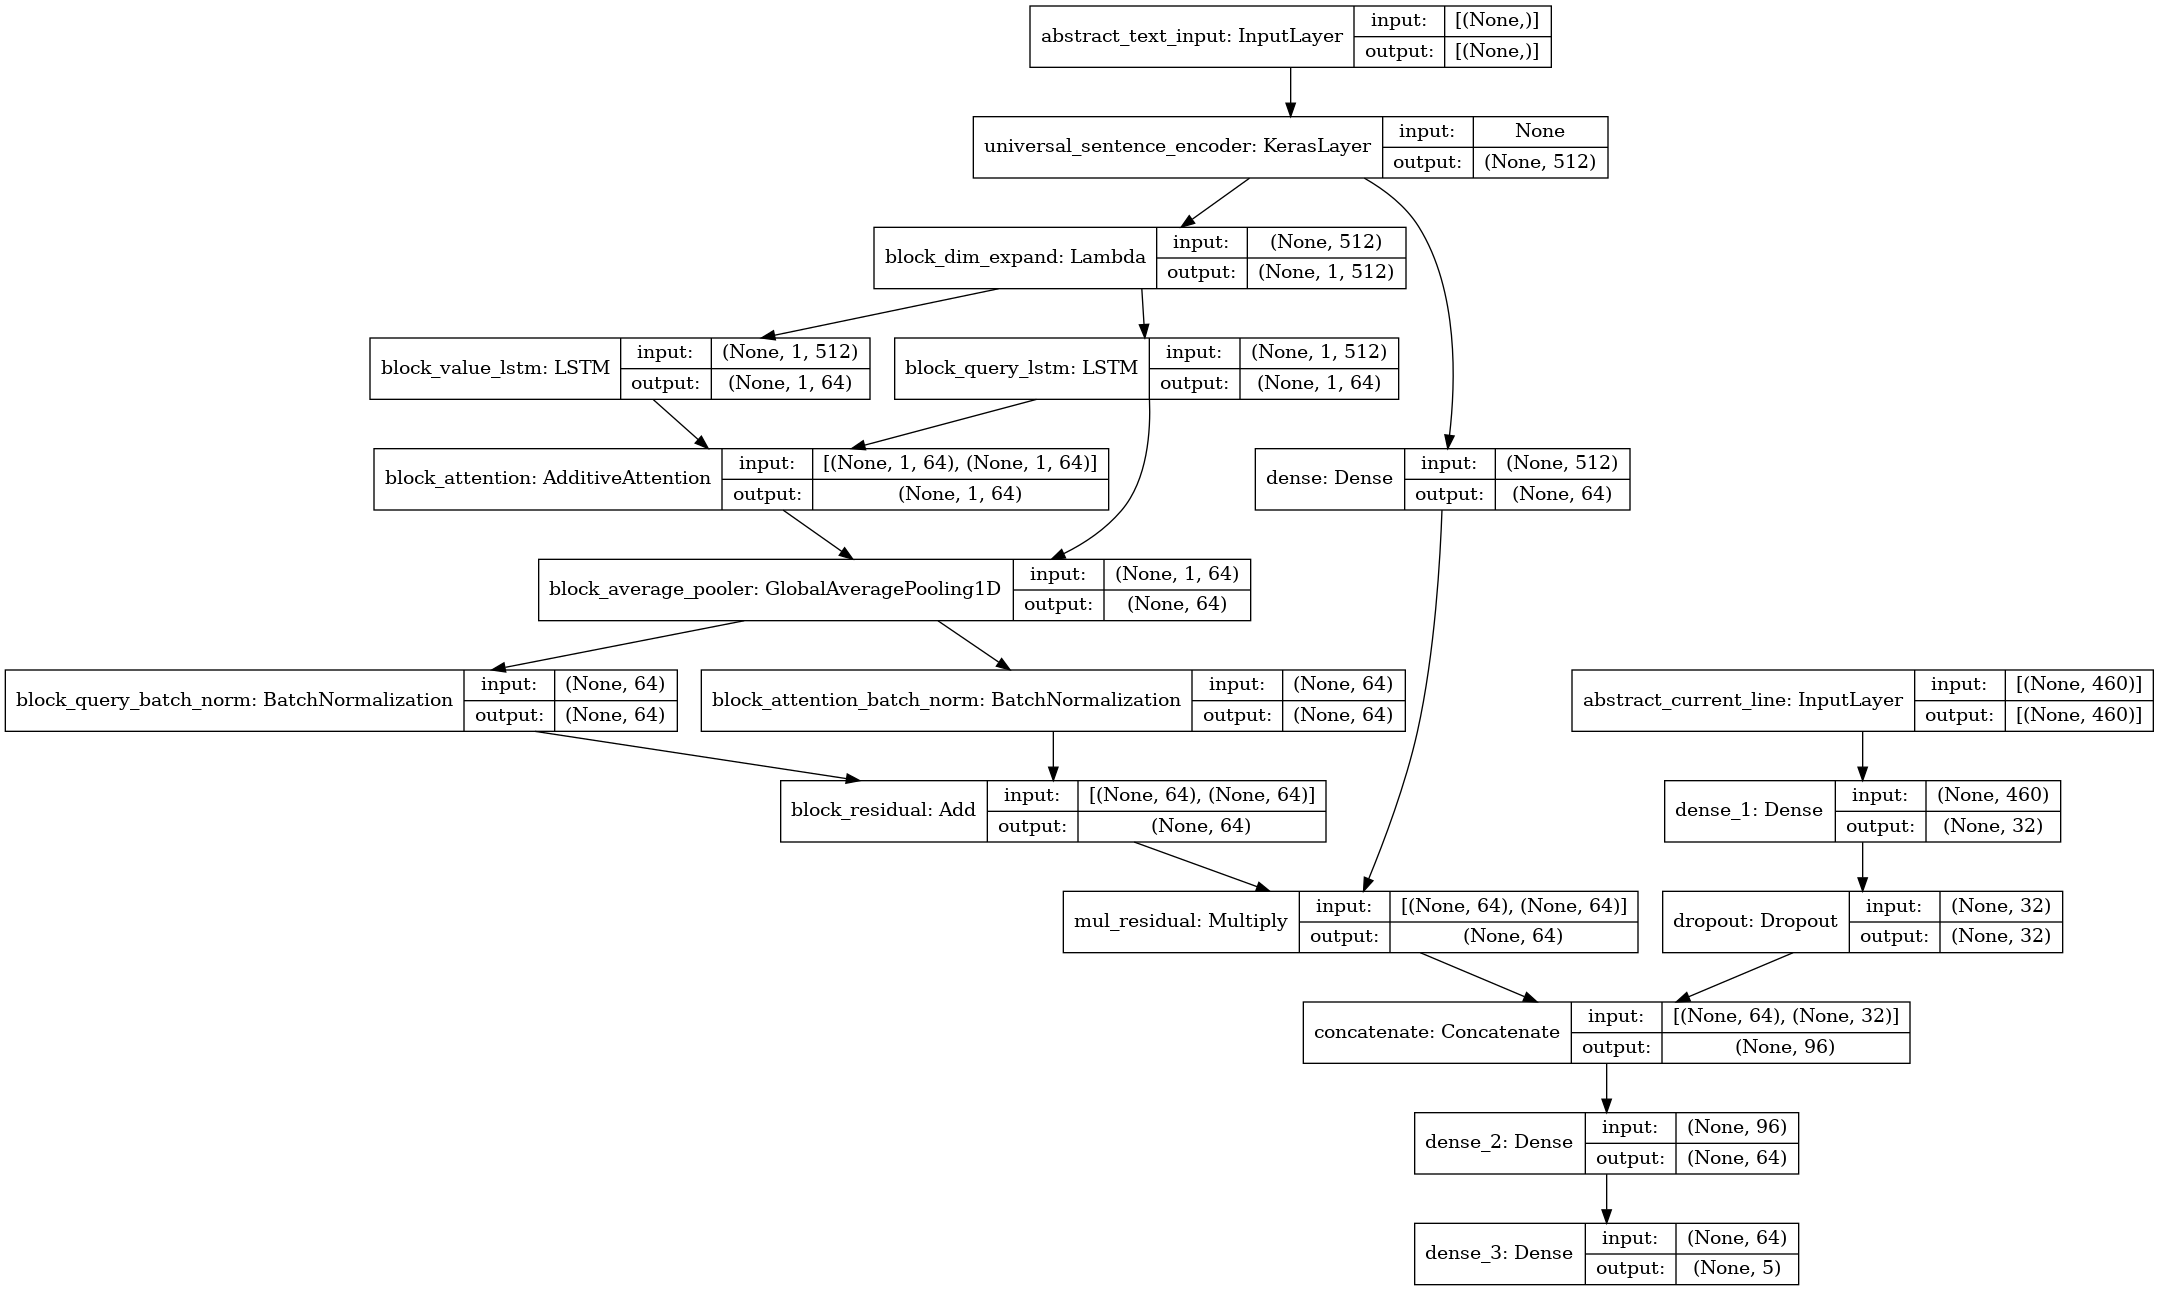

In [47]:
# Explore model visually
plot_model(
    model,
    show_shapes=True,
    expand_nested=True
)

In [48]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}
    
    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

<a id=6.1></a>
### Define Callbacks and Metrics for Model Training

In [49]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    restore_best_weights=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    factor=0.1,
    verbose=1)

EPOCHS = 10
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

<a id=6.2></a>
### Compile & Train Model

In [50]:
tf.random.set_seed(42)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

print(f'Training {model.name}.')
print(f'Train on {train_sentences_count} samples, validate on {val_sentences_count} samples.')
print('----------------------------------')

model_history = train_model(
    model, EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training use_attention_model.
Train on 180040 samples, validate on 30212 samples.
----------------------------------
Epoch 1/10
5627/5627 [==============================] - 107s 17ms/step - loss: 0.6949 - accuracy: 0.8495 - val_loss: 0.6364 - val_accuracy: 0.8768
Epoch 2/10
5627/5627 [==============================] - 95s 17ms/step - loss: 0.6308 - accuracy: 0.8796 - val_loss: 0.6292 - val_accuracy: 0.8781
Epoch 3/10
5627/5627 [==============================] - 95s 17ms/step - loss: 0.6121 - accuracy: 0.8882 - val_loss: 0.6282 - val_accuracy: 0.8791
Epoch 4/10
5627/5627 [==============================] - 95s 17ms/step - loss: 0.5982 - accuracy: 0.8954 - val_loss: 0.6271 - val_accuracy: 0.8796
Epoch 5/10
5627/5627 [==============================] - 97s 17ms/step - loss: 0.5855 - accuracy: 0.9022 - val_loss: 0.6362 - val_accuracy: 0.8761
Epoch 6/10
5627/5627 [==============================] - 94s 17ms/step - loss: 0.5741 - accuracy: 0.9089 - val_loss: 0.6416 - val_accuracy: 0.8753

Epoch

In [51]:
# evaluate the model on the test data to see how it performs
model.evaluate(test_ds)

942/942 [==============================] - 11s 12ms/step - loss: 0.6383 - accuracy: 0.8766


[0.6382759213447571, 0.8765555024147034]

> It seems like we've achieved similar scores on the test data as seen with the train and validation data. Time to generate predictions and associated probabilities for further inspection

<a id=7.1></a>
### Generate Validation Probabilities & Predictions

In [52]:
# generate validation probabilities
val_probabilities = model.predict(val_ds, verbose=1)
val_probabilities

945/945 [==============================] - 12s 11ms/step


array([[0.8086025 , 0.01570274, 0.01813276, 0.14349967, 0.01406235],
       [0.7143957 , 0.02181365, 0.01361344, 0.2356725 , 0.0145047 ],
       [0.3266899 , 0.00988779, 0.01797599, 0.6333921 , 0.01205426],
       ...,
       [0.0182509 , 0.03368485, 0.01490147, 0.02112213, 0.91204065],
       [0.05809063, 0.38902214, 0.02616001, 0.04259373, 0.48413348],
       [0.01453389, 0.9460249 , 0.00960265, 0.02415183, 0.00568673]],
      dtype=float32)

In [53]:
# generate validation predictions with argmax
val_predictions = tf.argmax(val_probabilities, axis=1)
val_predictions

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

<a id=7.2></a>
### Generate Test Probabilities & Predictions

In [54]:
# generate test probabilities
test_probabilities = model.predict(test_ds, verbose=1)
test_probabilities

942/942 [==============================] - 10s 11ms/step


array([[0.32028446, 0.02373511, 0.01864091, 0.62201977, 0.01531975],
       [0.42927963, 0.03201703, 0.15441687, 0.26986924, 0.11441725],
       [0.01791771, 0.02113371, 0.85151255, 0.01843959, 0.09099637],
       ...,
       [0.01967937, 0.03641218, 0.03197495, 0.01816074, 0.8937728 ],
       [0.05006664, 0.15386653, 0.07222368, 0.03554837, 0.6882948 ],
       [0.02060506, 0.9192409 , 0.01863441, 0.0217551 , 0.01976456]],
      dtype=float32)

In [55]:
# generate test predictions with argmax
test_predictions = tf.argmax(test_probabilities, axis=1)
test_predictions

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 0, 2, ..., 4, 4, 1])>

<a id=7.3></a>
### Plot Model History

We need to plot the model training performance in order to identify if overfitting or underfitting occured during the model's training.

In [56]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

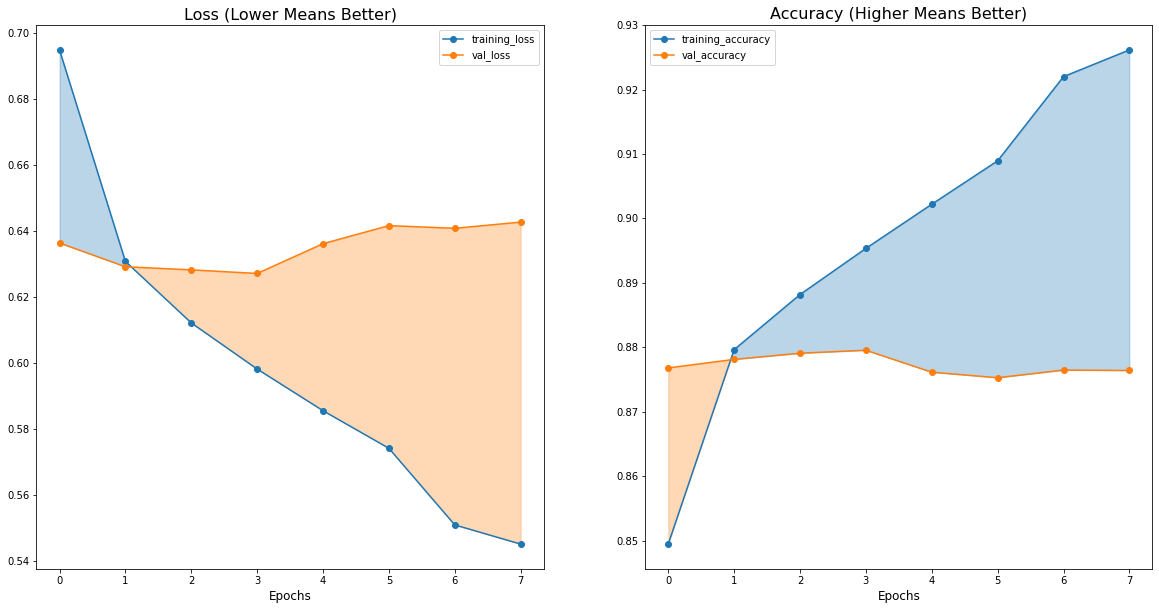

In [57]:
# plot model training history 
plot_training_curves(model_history)

In [58]:
# Generate validation classification report
print(classification_report(val_labels_encoded, val_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.71      0.84      0.77      3449
 CONCLUSIONS       0.92      0.92      0.92      4582
     METHODS       0.91      0.93      0.92      9964
   OBJECTIVE       0.76      0.53      0.63      2376
     RESULTS       0.92      0.90      0.91      9841

    accuracy                           0.88     30212
   macro avg       0.84      0.83      0.83     30212
weighted avg       0.88      0.88      0.88     30212



In [59]:
# Generate test classification report
print(classification_report(test_labels_encoded, test_predictions, target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.72      0.84      0.78      3621
 CONCLUSIONS       0.92      0.92      0.92      4571
     METHODS       0.90      0.94      0.92      9897
   OBJECTIVE       0.74      0.52      0.61      2333
     RESULTS       0.92      0.90      0.91      9713

    accuracy                           0.88     30135
   macro avg       0.84      0.82      0.83     30135
weighted avg       0.88      0.88      0.87     30135



<a id=7.5></a>
### Inspect Validation Performance

In [60]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = round(accuracy_score(y_true, y_pred), 5)
    top_3_accuracy = round(top_k_accuracy_score(y_true, y_probabilities, k=3), 5)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels_encoded, 
                                                                                 test_predictions, 
                                                                                 average="weighted")
    model_precision, model_recall, model_f1 = round(model_precision, 5), round(model_recall, 5), round(model_f1, 5)
    model_matthews_corrcoef = round(matthews_corrcoef(y_true, y_pred), 5)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef}\n')
    print('=============================================')
    
    return

In [61]:
generate_preformance_scores(val_labels_encoded, val_predictions, val_probabilities)


Performance Metrics:

accuracy_score:		0.87955

_____________________________________________
top_3_accuracy_score:	0.99474

_____________________________________________
precision_score:	0.87664

_____________________________________________
recall_score:		0.87656

_____________________________________________
f1_score:		0.87444

_____________________________________________
matthews_corrcoef:	0.8382



<a id=7.6></a>
### Inspect Test Performance

In [62]:
generate_preformance_scores(test_labels_encoded, test_predictions, test_probabilities)


Performance Metrics:

accuracy_score:		0.87656

_____________________________________________
top_3_accuracy_score:	0.99383

_____________________________________________
precision_score:	0.87664

_____________________________________________
recall_score:		0.87656

_____________________________________________
f1_score:		0.87444

_____________________________________________
matthews_corrcoef:	0.83451



In [63]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=11): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size},
        fmt='d',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    
    # Plot confusion matrix
    plt.show()
    
    return

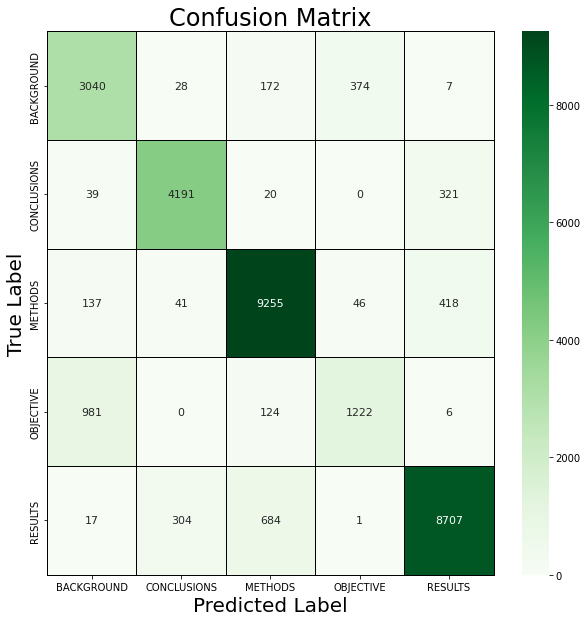

In [64]:
# View Confusion Matrix
plot_confusion_matrix(
    test_labels_encoded, 
    test_predictions, 
    figsize=(10, 10), 
    classes=list(class_names))

In [65]:
test_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS
...,...,...,...,...,...,...,...
30130,24261927,24261927_13_18,There was a statistically significant between-...,13,18,13_18,RESULTS
30131,24261927,24261927_14_18,There were no statistically significant betwee...,14,18,14_18,RESULTS
30132,24261927,24261927_15_18,There was no significant association between s...,15,18,15_18,RESULTS
30133,24261927,24261927_16_18,No adverse effects were reported .,16,18,16_18,RESULTS


In [66]:
# Get top 3 predictions
top_3_values, top_3_indices = tf.nn.top_k(test_probabilities, k=3)

In [67]:
%%time
# copy test_df
test_pred_df = test_df.copy()

# add best predictions
test_pred_df['prediction'] = [class_names[_] for _ in top_3_indices[:, 0]]
test_pred_df['probability'] = list(top_3_values[:, 0].numpy())

# add 2nd best predictions
test_pred_df['prediction_2'] = [class_names[_] for _ in top_3_indices[:, 1]]
test_pred_df['probability_2'] = list(top_3_values[:, 1].numpy())

# add 3rd best predictions
test_pred_df['prediction_3'] = [class_names[_] for _ in top_3_indices[:, 2]]
test_pred_df['probability_3'] = list(top_3_values[:, 2].numpy())

CPU times: user 14.2 s, sys: 5.18 ms, total: 14.2 s
Wall time: 14.2 s


In [68]:
test_pred_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target,prediction,probability,prediction_2,probability_2,prediction_3,probability_3
0,24845963,24845963_0_9,This study analyzed liver function abnormaliti...,0,9,0_9,BACKGROUND,OBJECTIVE,0.622020,BACKGROUND,0.320284,CONCLUSIONS,0.023735
1,24845963,24845963_1_9,A post hoc analysis was conducted with the use...,1,9,1_9,RESULTS,BACKGROUND,0.429280,OBJECTIVE,0.269869,METHODS,0.154417
2,24845963,24845963_2_9,Liver function tests ( LFTs ) were measured at...,2,9,2_9,RESULTS,METHODS,0.851513,RESULTS,0.090996,CONCLUSIONS,0.021134
3,24845963,24845963_3_9,Survival analyses were used to assess the asso...,3,9,3_9,RESULTS,RESULTS,0.499566,METHODS,0.433848,BACKGROUND,0.023049
4,24845963,24845963_4_9,The percentage of patients with abnormal LFTs ...,4,9,4_9,RESULTS,RESULTS,0.784742,METHODS,0.139800,CONCLUSIONS,0.028893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30130,24261927,24261927_13_18,There was a statistically significant between-...,13,18,13_18,RESULTS,RESULTS,0.915064,METHODS,0.022060,BACKGROUND,0.021590
30131,24261927,24261927_14_18,There were no statistically significant betwee...,14,18,14_18,RESULTS,RESULTS,0.927438,CONCLUSIONS,0.023118,OBJECTIVE,0.021289
30132,24261927,24261927_15_18,There was no significant association between s...,15,18,15_18,RESULTS,RESULTS,0.893773,CONCLUSIONS,0.036412,METHODS,0.031975
30133,24261927,24261927_16_18,No adverse effects were reported .,16,18,16_18,RESULTS,RESULTS,0.688295,CONCLUSIONS,0.153867,METHODS,0.072224


In [69]:
def view_prediction(pred_df, sample_index):
    sample = pred_df.iloc[sample_index]
    
    print('====================================================')
    print(f'id:\t\t{sample.abstract_id}')
    print('____________________________________________________')
    print(f'text:\n\n{sample.abstract_text}')
    print('____________________________________________________')
    print(f'current_line:\t{sample.current_line}')
    print('____________________________________________________')
    print(f'target:\t\t{sample.target}')
    print('____________________________________________________')
    print(f'predictions:\n')
    print(f'1: {sample.prediction}({sample.probability})')
    print(f'2: {sample["prediction_2"]}({sample["probability_2"]})')
    print(f'3: {sample["prediction_3"]}({sample["probability_3"]})')
    print('====================================================')
    
    return

<a id=7.9></a>
### Inspect Least Accurate Predictions

In [70]:
least_accurate = test_pred_df.loc[test_pred_df.target == test_pred_df.prediction].sort_values('probability', inplace=False)

In [71]:
least_accurate.head(5).T

,26358,23975,6904,16936,16588
abstract_id,25749601,24295397,25194287,24562799,24811543
line_id,25749601_5_9,24295397_5_21,25194287_3_10,24562799_3_11,24811543_12_28
abstract_text,Qualitative implementation data suggested sign...,Both opportunistic screening and active case f...,"Results from smaller prospective , randomized ...","In addition , we compared plasma levels of MAp...",Mean trunk flexion angle and velocity signific...
line_number,5,5,3,3,12
total_lines,9,21,10,11,28
current_line,5_9,5_21,3_10,3_11,12_28
target,RESULTS,METHODS,BACKGROUND,BACKGROUND,RESULTS
prediction,RESULTS,METHODS,BACKGROUND,BACKGROUND,RESULTS
probability,0.288734,0.29746,0.307317,0.311338,0.311741
prediction_2,CONCLUSIONS,BACKGROUND,RESULTS,OBJECTIVE,OBJECTIVE


In [72]:
view_prediction(least_accurate, 0)

id:		25749601
____________________________________________________
text:

Qualitative implementation data suggested significant barriers around intervention characteristics , payment , eligibility criteria , the referral process , the need for champions ( ie , advocates ) , and the need to adapt during implementation of the intervention , which should be considered in future dissemination and implementation efforts .
____________________________________________________
current_line:	5_9
____________________________________________________
target:		RESULTS
____________________________________________________
predictions:

1: RESULTS(0.28873369097709656)
2: CONCLUSIONS(0.28079646825790405)
3: METHODS(0.26728537678718567)


In [73]:
view_prediction(least_accurate, 1)

id:		24295397
____________________________________________________
text:

Both opportunistic screening and active case finding took place among clients with high risk factors for diabetes .
____________________________________________________
current_line:	5_21
____________________________________________________
target:		METHODS
____________________________________________________
predictions:

1: METHODS(0.2974596619606018)
2: BACKGROUND(0.2623608708381653)
3: RESULTS(0.2336716204881668)


<a id=7.10></a>
### Inspect Most Inaccurate Predictions

In [74]:
most_inaccurate = test_pred_df.loc[test_pred_df.target != test_pred_df.prediction].sort_values('probability', inplace=False)

In [75]:
most_inaccurate.head(5).T

,10239,10088,1656,23023,28967
abstract_id,25608428,25406436,24460845,25515217,25259781
line_id,25608428_5_7,25406436_9_20,24460845_14_17,25515217_7_14,25259781_11_14
abstract_text,This study supported the 3-factor model of the...,Qualitative interviews suggested that more reg...,The study will also analyse health economic in...,"Our aims are to understand how , why , and for...",This SBHC intervention showed successful recru...
line_number,5,9,14,7,11
total_lines,7,20,17,14,14
current_line,5_7,9_20,14_17,7_14,11_14
target,CONCLUSIONS,RESULTS,CONCLUSIONS,BACKGROUND,CONCLUSIONS
prediction,METHODS,BACKGROUND,METHODS,CONCLUSIONS,METHODS
probability,0.266344,0.269888,0.274241,0.287488,0.292468
prediction_2,RESULTS,RESULTS,RESULTS,METHODS,CONCLUSIONS


In [76]:
view_prediction(most_inaccurate, 0)

id:		25608428
____________________________________________________
text:

This study supported the 3-factor model of the FACIT-Sp-12 .
____________________________________________________
current_line:	5_7
____________________________________________________
target:		CONCLUSIONS
____________________________________________________
predictions:

1: METHODS(0.2663438022136688)
2: RESULTS(0.26023221015930176)
3: BACKGROUND(0.18128499388694763)


In [77]:
wild_abstract_text = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of 
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS) 
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of 
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely 
causal variants using functionally informed fine-mapping, yielding 42 associations with less than 
five variants in the 95% credible set. Similarity-based clustering suggested roles for early 
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the 
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary 
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we 
experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by 
regulating vascular cell motility. Our analysis identifies and systematically characterizes >250 risk 
loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD."""

In [78]:
# view the abstract
print(wild_abstract_text)

The discovery of genetic loci associated with complex diseases has outpaced the elucidation of 
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS) 
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of 
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely 
causal variants using functionally informed fine-mapping, yielding 42 associations with less than 
five variants in the 95% credible set. Similarity-based clustering suggested roles for early 
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the 
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary 
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we 
experimentally validated the effect of an enhancer

In [79]:
wild_abstract_preprocessed = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .
Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .
We detected 241 associations, including 30 new loci . 
Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .
We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .
Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .
We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by three or more approaches .
Using CRISPR–Cas9, we experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by regulating vascular cell motility .
Our analysis identifies and systematically characterizes >250 risk loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD ."""

<a id=8.1></a>
### Preprocess the Wild Abstract
We need to preprocess the wild abstract text so that it is 'consumable' by the model. 

In [80]:
# Split the abstract into it's lines as seen in the original paper
wild_texts = [_  for _ in wild_abstract_preprocessed.split('\n')]

# convert the list of texts line into a numpy array
wild_texts = np.array(wild_texts).reshape((len(wild_texts), 1))
wild_texts.shape

(9, 1)

In [81]:
wild_texts

array([['The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .'],
       ['Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .'],
       ['We detected 241 associations, including 30 new loci . '],
       ['Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .'],
       ['We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .'],
       ['Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .'],
       ['We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by three or more approa

In [82]:
# generate the combined feature current_line for the wild abstract
wild_current_lines = [f'{_}_{len(wild_texts)}' for _ in range(len(wild_texts))]
print(wild_current_lines)

['0_9', '1_9', '2_9', '3_9', '4_9', '5_9', '6_9', '7_9', '8_9']


In [83]:
# one-hot encode the current_lines feature
wild_current_lines_transformed = line_one_hot_encoder.transform(np.array(wild_current_lines).reshape(-1, 1))
wild_current_lines_transformed.shape

(9, 460)

<a id=8.2></a>
### Generate Probabilities

In [84]:
wild_probabilities = model.predict((wild_texts, (wild_current_lines_transformed)), verbose=1)
wild_probabilities

1/1 [==============================] - 1s 1s/step


array([[0.8407172 , 0.01029547, 0.00570891, 0.13635539, 0.00692312],
       [0.26177108, 0.03642004, 0.37471682, 0.2744636 , 0.05262841],
       [0.06338099, 0.04530196, 0.61128205, 0.02958839, 0.2504466 ],
       [0.017438  , 0.03211081, 0.67758435, 0.02494048, 0.24792632],
       [0.06233398, 0.04389181, 0.38666642, 0.05556284, 0.4515449 ],
       [0.03172937, 0.05965295, 0.51313955, 0.04652553, 0.34895256],
       [0.03950277, 0.0648078 , 0.09212366, 0.0300404 , 0.77352536],
       [0.02717623, 0.8311297 , 0.04428194, 0.02640654, 0.0710056 ],
       [0.03851697, 0.90601754, 0.01125712, 0.03052966, 0.01367871]],
      dtype=float32)

<a id=8.3></a>
### View Wild Abstract Predictions

In [85]:
def view_wild_prediction(texts, current_lines, probabilities):
    for text, current_line, prob in zip(texts, current_lines, probabilities):
        top_3_probs, top_3_labels = tf.nn.top_k(prob, k=3)
        predicted_labels = [class_names[_] for _ in top_3_labels]
        print(f'Text:\n\n{text[0]}\n')
        print(f'Predictions:\n')
        print(f'1: {predicted_labels[0]}({top_3_probs[0]:.6f})')
        print(f'2: {predicted_labels[1]}({top_3_probs[1]:.6f})')
        print(f'3: {predicted_labels[2]}({top_3_probs[2]:.6f})')
        print('====================================================')
    
    return

In [86]:
view_wild_prediction(wild_texts, wild_current_lines, wild_probabilities)

Text:

The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .

Predictions:

1: BACKGROUND(0.840717)
2: OBJECTIVE(0.136355)
3: CONCLUSIONS(0.010295)
Text:

Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .

Predictions:

1: METHODS(0.374717)
2: OBJECTIVE(0.274464)
3: BACKGROUND(0.261771)
Text:

We detected 241 associations, including 30 new loci . 

Predictions:

1: METHODS(0.611282)
2: RESULTS(0.250447)
3: BACKGROUND(0.063381)
Text:

Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .

Predictions:

1: METHODS(0.677584)
2: RESULTS(0.247926)
3: CONCLUSIONS(0.032111)
Text:

We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .

Predictions:

1: RE

<a id=8.4></a>
### View the segmented abstract in color

In [87]:
def display_segemented_abstract(abstract_texts, labels, color=False):
    colors = {
        'BACKGROUND': 34,     # blue
        'OBJECTIVE': 35,      # magenta
        'METHODS': 32,        # green
        'RESULTS': 33,        # yellow
        'CONCLUSIONS': 31     # red
    }
    
    segmented_abstract = ""
    
    for text_line, text_label in zip(abstract_texts, labels):
        if color:
            segmented_abstract += '\033[1;{}m{:<12s}\n{:<12s}\n\n'.format(colors[text_label], text_label, text_line[0])
        else:
            segmented_abstract += '{:<12s}\n {:<12s}\n'.format(text_label, text_line[0])
            
    return segmented_abstract

In [88]:
wild_predictions = np.argmax(wild_probabilities, axis=1)
wild_labels = [class_names[_] for _ in wild_predictions]

In [89]:
wild_segmented_abstract = display_segemented_abstract(wild_texts, wild_labels, color=True)
print(wild_segmented_abstract)

BACKGROUND  
The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .

METHODS     
Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .

METHODS     
We detected 241 associations, including 30 new loci . 

METHODS     
Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .

RESULTS     
We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .

METHODS     
Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .

RESULTS     
We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by thre